In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [19]:
with open(f'{configs.engram_dir}02_gamma_v_rsteps/results.p', 'rb') as f:
    results = pickle.load(f)

In [20]:
for key in results.keys():
    results[key] = np.array(results[key])

In [38]:
nonlinearities = results['nonlinearities']
gammas = results['gammas']
rsteps = results['rsteps']
M_maes = results['M_maes']
T_maes = results['T_maes']

In [39]:
xs = np.sort(np.unique(results['gammas']))
ys = np.sort(np.unique(results['rsteps']))

## Plot test loss for different gammas and recurrent steps

None


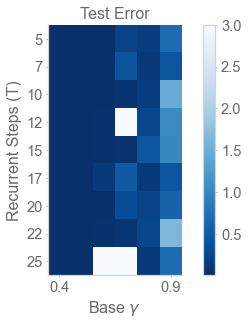

relu


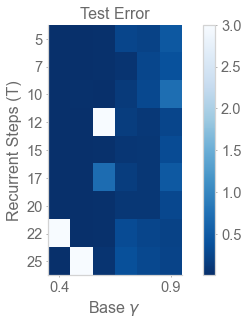

In [78]:
for nonlinearity in np.unique(nonlinearities):
    print(nonlinearity)
    mat = np.zeros((xs.size, ys.size))*np.nan
    for x_idx, x in enumerate(xs):
        for y_idx, y in enumerate(ys):
            idxs = np.logical_and(
                gammas==x, nonlinearities==nonlinearity
                )
            idxs = np.logical_and(rsteps==y, idxs)
            vals = M_maes[idxs]
            mat[x_idx][y_idx] = np.mean(vals)
        
    plt.figure(figsize=(6.4, 4.8))
    plt.imshow(mat.T, cmap="Blues_r", vmax=3., aspect=1.25)
    plt.yticks(np.arange(ys.size), ys)
    plt.xticks([0, xs.size-1], [xs[0], xs[-1]])
    plt.ylabel('Recurrent Steps (T)')
    plt.xlabel('Base $\gamma$')
    plt.colorbar()
    plt.title("Test Error")
    plt.tight_layout()
    plt.savefig(f"gamma_v_rsteps_{nonlinearity}.png", dpi=300)
    plt.show()

In [80]:
ys

array([ 5,  7, 10, 12, 15, 17, 20, 22, 25])